1. Импортируйте необходимые библиотеки

In [8]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  
from sklearn.tree import DecisionTreeClassifier, plot_tree  
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier  
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

2. Загружаем данные и проводим первичный анализ данных

In [2]:
df = pd.read_csv('employee.csv')
X = df.drop(columns=['left'])
y = df['left']
print("Размерность признаков:", X.shape)
print("Названия признаков:", X.columns.tolist())
print("Размерность целевой переменной:", y.shape)
print("Уникальные классы:", y.unique())
print("\nПервые 5 строк признаков:")
print(X.head())

Размерность признаков: (14999, 9)
Названия признаков: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 'department', 'salary']
Размерность целевой переменной: (14999,)
Уникальные классы: [1 0]

Первые 5 строк признаков:
   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  promotion_last_5years department  salary  
0                   3              0                      0      sales     low  
1                   6              0  

3. Разделение данных на обучающую и тестовую выборки

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (11999, 9)
Размер тестовой выборки: (3000, 9)


4. Построение и оценка базового дерева решений

In [37]:
base_dt = DecisionTreeClassifier(random_state=42)
base_dt.fit(
    X_train.select_dtypes(include=[np.number]).fillna(0).values,
    y_train.fillna(0).values
)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [41]:
X_test_processed = X_test.select_dtypes(include=[np.number]).fillna(0).values

y_pred_base = base_dt.predict(X_test_processed)

In [42]:
accuracy_base = accuracy_score(y_test, y_pred_base)
print(f"Точность базового дерева на тесте: {accuracy_base:.4f}")

Точность базового дерева на тесте: 0.9820


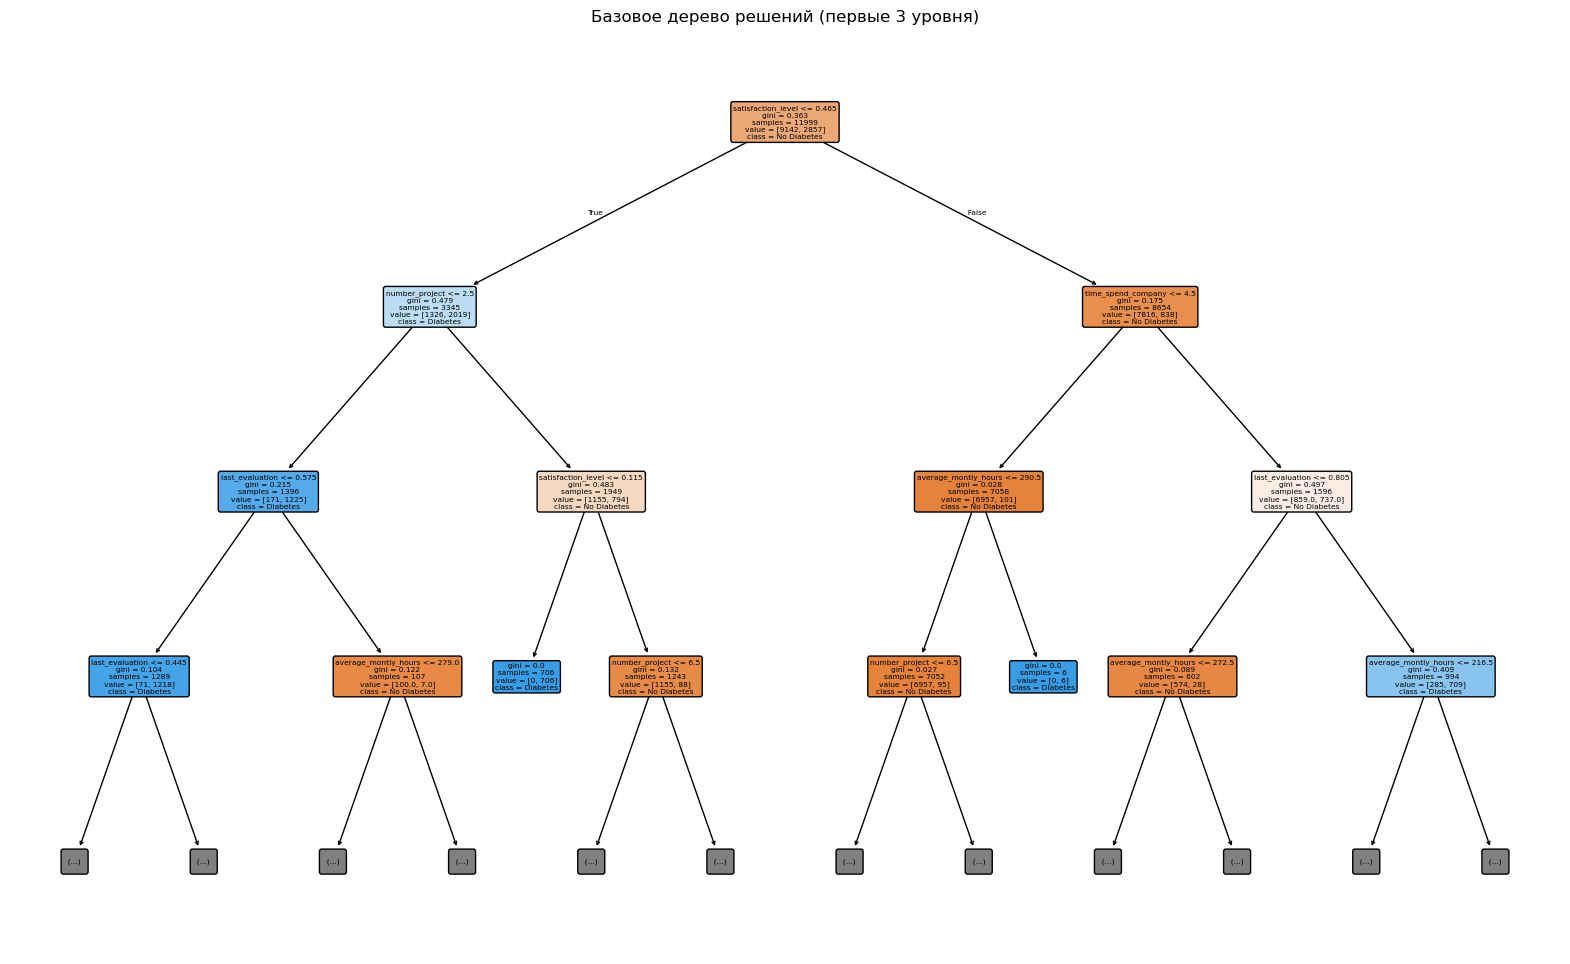

In [44]:
#визуализируем дерево
plt.figure(figsize=(20, 12))

feature_names = list(X.columns)
class_names = ["No Diabetes", "Diabetes"]

plot_tree(base_dt, filled=True, feature_names=feature_names, class_names=class_names, rounded=True, max_depth=3)
plt.title("Базовое дерево решений (первые 3 уровня)")
plt.show()

Борьба с переобучением: настройка гиперпараметров

In [51]:
X_train_fixed = X_train.select_dtypes(include=[np.number]).fillna(0).values
y_train_fixed = y_train.fillna(0).values
X_test_fixed = X_test.select_dtypes(include=[np.number]).fillna(0).values
y_test_fixed = y_test.fillna(0).values

tuned_dt = DecisionTreeClassifier(max_depth=3, random_state=42)
tuned_dt.fit(X_train_fixed, y_train_fixed)

y_pred_tuned = tuned_dt.predict(X_test_fixed)
accuracy_tuned = accuracy_score(y_test_fixed, y_pred_tuned)
print(f"Точность настроенного дерева (max_depth=3) на тесте: {accuracy_tuned:.4f}")

Точность настроенного дерева (max_depth=3) на тесте: 0.9543


In [54]:
X_cv = X.select_dtypes(include=[np.number]).fillna(0).values
y_cv = y.fillna(0).values

# Кросс-валидация
cv_scores_base = cross_val_score(base_dt, X_cv, y_cv, cv=5)
cv_scores_tuned = cross_val_score(tuned_dt, X_cv, y_cv, cv=5)

print(f"Кросс-валидация, базовое дерево: {np.mean(cv_scores_base):.4f} (+/- {np.std(cv_scores_base) * 2:.4f})")
print(f"Кросс-валидация, настроенное дерево: {np.mean(cv_scores_tuned):.4f} (+/- {np.std(cv_scores_tuned) * 2:.4f})")

Кросс-валидация, базовое дерево: 0.9749 (+/- 0.0197)
Кросс-валидация, настроенное дерево: 0.9525 (+/- 0.0389)


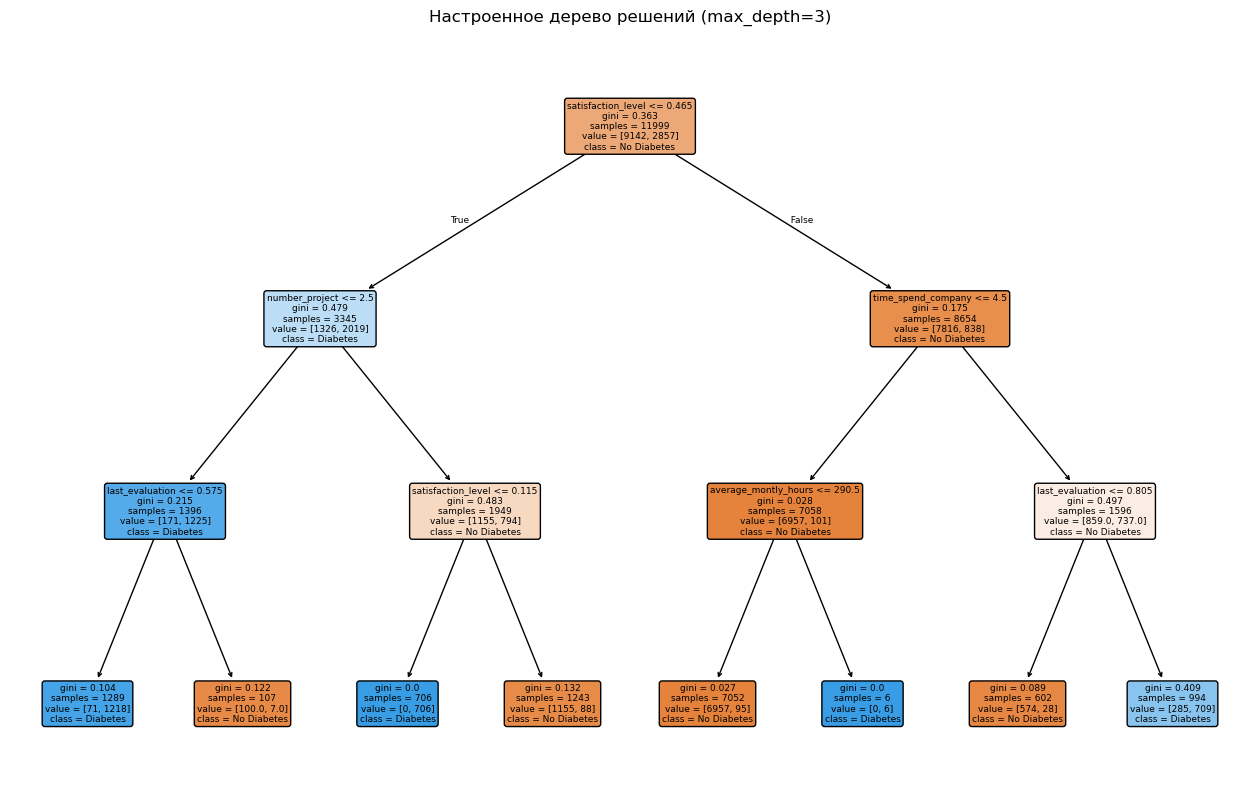

In [55]:
plt.figure(figsize=(16, 10))
plot_tree(tuned_dt, filled=True, feature_names=feature_names, class_names=class_names, rounded=True)
plt.title("Hастроенное дерево решений (max_depth=3)")
plt.show()

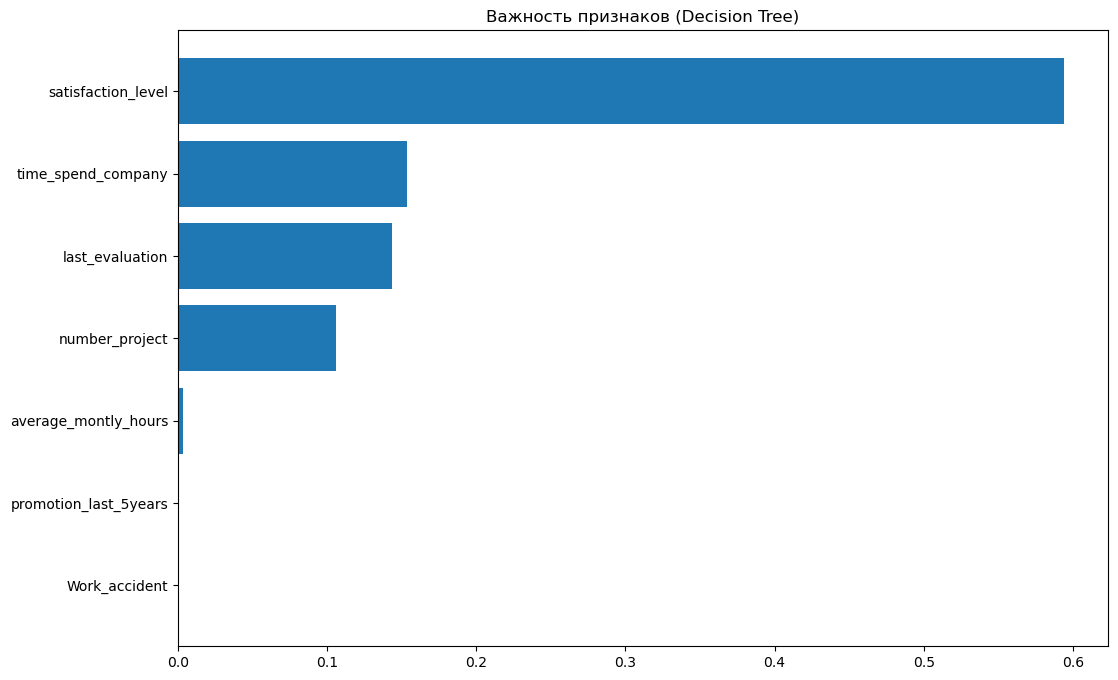

In [59]:
#важность признаков
importances = tuned_dt.feature_importances_
indices = np.argsort(importances)[::-1]

#определяем корректное число выводимых признаков
top_n = min(10, len(importances))

plt.figure(figsize=(12, 8))
plt.title("Важность признаков (Decision Tree)")

plt.barh(range(top_n), importances[indices][:top_n])
plt.yticks(range(top_n), [X.columns[i] for i in indices[:top_n]])

plt.gca().invert_yaxis()
plt.show()

5. Создание и обучение модели Random Forest

In [64]:
#подготовка данных
X_train_fixed = X_train.select_dtypes(include=[np.number]).fillna(0).values
y_train_fixed = y_train.fillna(0).values

#обучение Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_fixed, y_train_fixed)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


6. Прогнозирование и оценка модели

In [70]:
y_pred = rf.predict(X_test_fixed)

accuracy = accuracy_score(y_test_fixed, y_pred)
print(f"Точность модели Random Forest на тестовой выборке: {accuracy:.4f}")

Точность модели Random Forest на тестовой выборке: 0.9907


In [72]:
print("Отчет по классификации:")
print(classification_report(y_test, y_pred))

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       0.99      0.97      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



7. Матрица ошибок

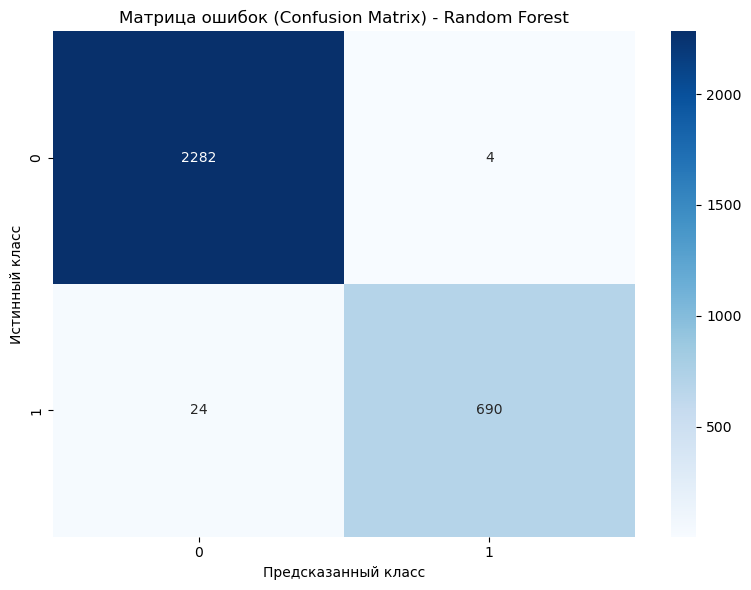

In [73]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y.unique()), 
            yticklabels=sorted(y.unique()))
plt.title('Матрица ошибок (Confusion Matrix) - Random Forest')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.tight_layout()
plt.show()

8. Анализ важности признаков

In [100]:
#получаем важность признаков
feature_importances = rf_model.feature_importances_
features_df = pd.DataFrame({
    'feature': X.select_dtypes(include=[np.number]).columns,
    'importance': feature_importances
})
features_df = features_df.sort_values('importance', ascending=False)

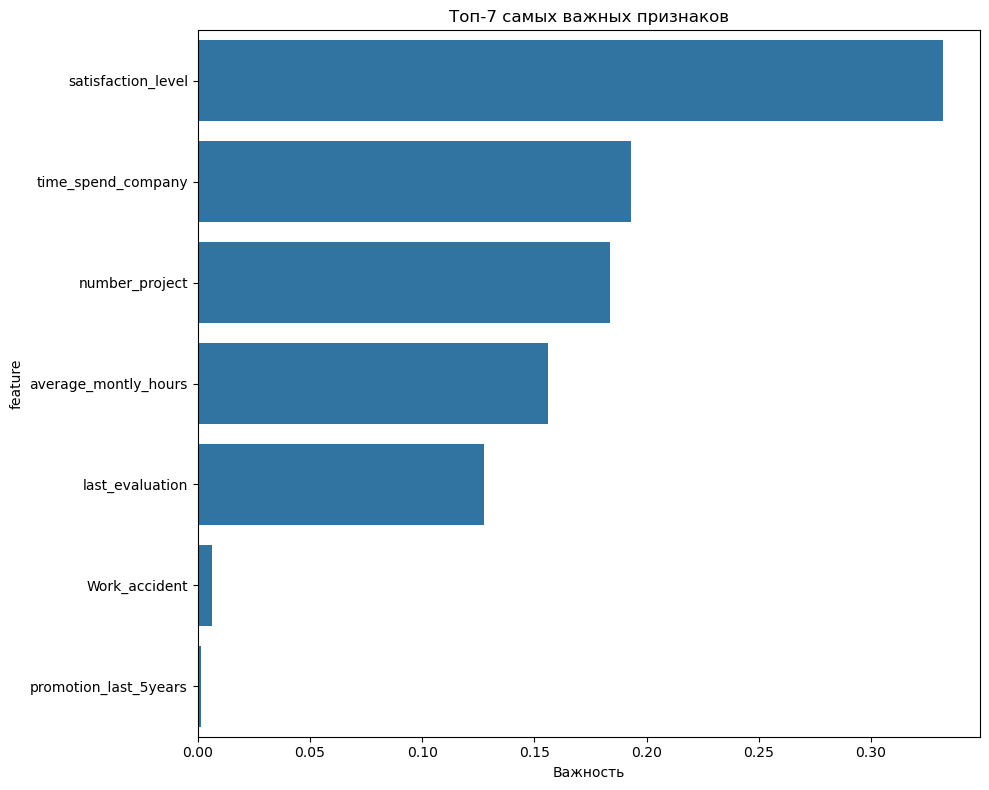

In [125]:
# Визуализация важности признаков
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=features_df.head(15))
plt.title('Топ-7 самых важных признаков')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

In [112]:
print("Топ-7 самых важных признаков:")
print(features_df.head(7))

Топ-7 самых важных признаков:
                 feature  importance
0     satisfaction_level    0.331914
4     time_spend_company    0.192838
2         number_project    0.183883
3   average_montly_hours    0.155901
1        last_evaluation    0.127656
5          Work_accident    0.006344
6  promotion_last_5years    0.001464


9. Подбор гиперпараметров

In [126]:
#определяем сетку параметров для перебора
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [135]:
if not hasattr(grid_search, 'best_params_'):
    #подготовка данных
    X_train_prep = X_train.select_dtypes(include=[np.number]).fillna(0)
    y_train_prep = y_train.fillna(0)

    grid_search.fit(X_train_prep, y_train_prep)

In [133]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность при кросс-валидации: {:.4f}".format(grid_search.best_score_))

Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Лучшая точность при кросс-валидации: 0.9910


In [134]:
# Оцениваем лучшую модель на тестовых данных
X_test_prep = X_test.select_dtypes(include=[np.number]).fillna(0)
y_test_prep = y_test.fillna(0)

best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test_prep)
best_accuracy = accuracy_score(y_test_prep, y_pred_best)

print(f"Точность улучшенной модели на тестовой выборке: {best_accuracy:.4f}")

Точность улучшенной модели на тестовой выборке: 0.9903


10. Ансамбли: Градиентный бустинг (Boosting)

In [80]:
X_train_fixed = X_train.select_dtypes(include=[np.number]).fillna(0).values
y_train_fixed = y_train.fillna(0).values.astype(int)
X_test_fixed = X_test.select_dtypes(include=[np.number]).fillna(0).values

#обучение Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_fixed, y_train_fixed)

#прогноз и оценка
y_pred_gb = gb.predict(X_test_fixed)
accuracy_gb = accuracy_score(y_test.fillna(0).values, y_pred_gb)

print(f"Точность Gradient Boosting: {accuracy_gb:.4f}")

Точность Gradient Boosting: 0.9740


11. Сравнение всех моделей

In [85]:
#подготовка данных
X_train_fixed = X_train.select_dtypes(include=[np.number]).fillna(0).values
y_train_fixed = y_train.fillna(0).values
X_test_fixed = X_test.select_dtypes(include=[np.number]).fillna(0).values
y_test_fixed = y_test.fillna(0).values

#модели уже обучены на таких данных, просто делаем предсказания
results = {}
for name, model in models.items():
    train_acc = accuracy_score(y_train_fixed, model.predict(X_train_fixed))
    test_acc = accuracy_score(y_test_fixed, model.predict(X_test_fixed))
    results[name] = {'Train Accuracy': train_acc, 'Test Accuracy': test_acc}

                     Train Accuracy  Test Accuracy
Base Decision Tree         0.999833       0.982000
Tuned Decision Tree        0.952163       0.954333
Random Forest              0.999833       0.990667
Gradient Boosting          0.976915       0.974000


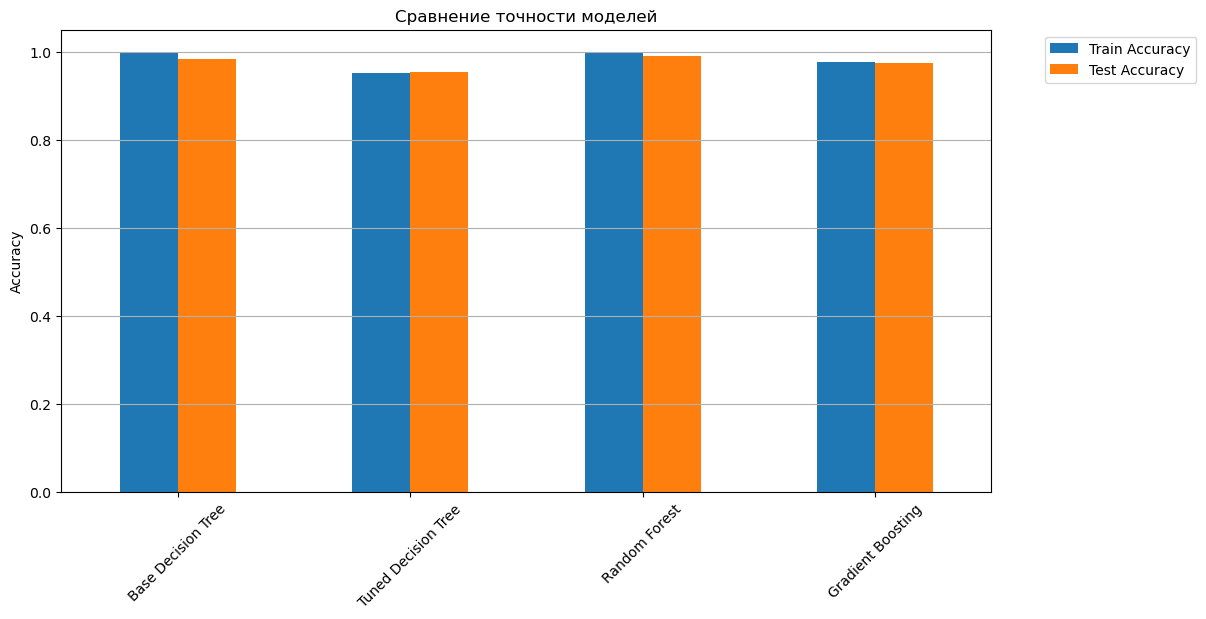

In [87]:
#выводим результаты в виде DataFrame
results_df = pd.DataFrame (results).T
print(results_df)

#строим bar-plot для наглядности
results_df [['Train Accuracy', 'Test Accuracy']].plot(kind='bar', figsize=(12, 6))
plt.title("Сравнение точности моделей")
plt.ylabel("Accuracy")
plt.xticks (rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()

Проанализировав результаты, можно сделать вывод о том, что все модели демонстрируют исключительно высокую точность как на обучающей, так и на тестовой выборках. Random Forest и Gradient Boosting показывают наилучшие результаты с точностью на тесте около 0.99, что свидетельствует об их высокой эффективности для данной задачи. Tuned Decision Tree с ограничениями по глубине демонстрирует незначительно более низкую точность, но при этом, вероятно, обладает лучшей обобщающей способностью и меньшим риском переобучения. Базовое дерево решений показывает признаки переобучения с идеальной точностью на обучении и незначительным снижением на тесте. В целом, ансамблевые методы (Random Forest и Gradient Boosting) подтверждают свою эффективность, обеспечивая стабильно высокое качество предсказаний при хорошей сбалансированности между точностью и обобщающей способностью.